### Credits and thanks for this tutorial go to the NIX project core contributor Achilleas Koutsou

## A note on HDF5 file corruption and general file handling


If the execution of a script, or an interactive session, is abruptly ended without closing a NIX file, the file may remain in an inconsistent, corrupted state [1].  This can prevent retrieval of data from the file.

[1] https://stackoverflow.com/questions/31287744/corrupt-files-when-creating-hdf5-files-without-closing-them-h5py

HDF5 files in Python, and by extention NIX files, are closed automatically by the garbage collector when the interpreter exits.  However, it is generally good practice to open NIX files using a context manager.
```python
with nixio.File("data.nix") as nixfile:
    ...
```
Using the `with` statement, the file is closed automatically when the context exits, i.e., when the block ends execution, even if it ends prematurely.

This practice can save you from some situations, for example exceptions being raised.

**However**, this will still likely not save you from an interpreter crash and will certainly not save you from an OS-level crash or power failure.

**Always keep backups of your data files.**

# NIX peculiarities

Data manipulation in NIX can occasionally present unexpected behaviour.  This often manifests as performance issues or unexpected errors.  It helps to understand how or why these peculiarities arise.  Most situations are not the result of a bug in the library, but specific design decisions that accommodate most common use cases or are consequences of other, more important or historical design decisions.

## Object IDs
- Each object has a `name` and `ID` (UUID).
- Data retrieval methods usually allow you to specify one or the other as the first positional argument (`identifier`).
- The nix library method determines how to find an object by trying to parse the `identifier` argument as a UUID and falling back to treating it as a `name` when that fails.
- **Don't use a UUID (like string) as `name` when creating objects.**

In [1]:
import os
import uuid
import nixio

workdir = "."
nix_filename = os.path.join(workdir, "uuid_names.nix")
nf = nixio.File(nix_filename, nixio.FileMode.Overwrite)

# create a block with a UUID as its name
name = str(uuid.uuid4())
blk = nf.create_block(name, "test-block")
blk_name = blk.name
blk_id = blk.id
print(f"Created block with name '{blk_name}' and ID '{blk_id}'")

Created block with name '903c6617-af42-4048-ae6e-8dcddbb8a36a' and ID '9e08e9be-bb46-4b8e-9426-48ca5e7994c9'


In [2]:
# Try to retrieve the Block by its name
try:
    blk = nf.blocks[blk_name]
except KeyError as ke:
    # let's catch the exception and print it
    # in a normal script, this would interrupt execution
    print(ke.args[0])

Item not found '903c6617-af42-4048-ae6e-8dcddbb8a36a'


In [3]:
# We can still retrieve the block via its UUID or simply via the index
blk = nf.blocks[blk_id]
print(f"Block retrieved by ID: {blk}")
print(f"Block retrieved by index: {nf.blocks[0]}")


Block retrieved by ID: Block: {name = 903c6617-af42-4048-ae6e-8dcddbb8a36a, type = test-block}
Block retrieved by index: Block: {name = 903c6617-af42-4048-ae6e-8dcddbb8a36a, type = test-block}


**Don't use a UUID (like string) as `name` when creating objects.**

In [4]:
nf.close()

## Object retrieval efficiency

Retrieving objects in NIX is usually very efficient.  Objects can be retrieved in constant time, if the user understands how objects are indexed.

Object indexing is very flexible: it supports retrieving objects by their `name`, `index`, or `ID`.  Normally, objects are indexed by their unique `name`.

_Note: The examples below use `DataArray` objects to demonstrate object retrieval.  This behaviour holds for all types of objects._

In [5]:
nix_filename = os.path.join(workdir, "block_time_retrieve.nix")
nf = nixio.File(nix_filename, nixio.FileMode.Overwrite)
blk = nf.create_block("block-retrieve", "demo-block")

# create 200 data arrays in a block and store their names and IDs
da_names = []
da_ids = []
for idx in range(200):
    da_name = f"da-{idx:04}"
    # the actual data being stored is unimportant here
    da = blk.create_data_array(da_name, "demo-data-array", data=[0])
    da_names.append(da_name)
    da_ids.append(da.id)

We retrieve each `DataArray` by its name and measure the time.

We use a very crude measurement method here of simply subtracting the timestamp after the call from the one before the call.  This is accurate enough for our purposes.

In [6]:
import time

def nix_read_times(nix_obj, access_list):
    read_times = []
    for itm in access_list:
        t0 = time.time()
        nix_obj.data_arrays[itm]
        duration = time.time() - t0
        read_times.append(duration)

    return read_times

# Access all 200 DataArrays by name and record the read times
name_read_times = nix_read_times(blk, da_names)


<IPython.core.display.Javascript object>


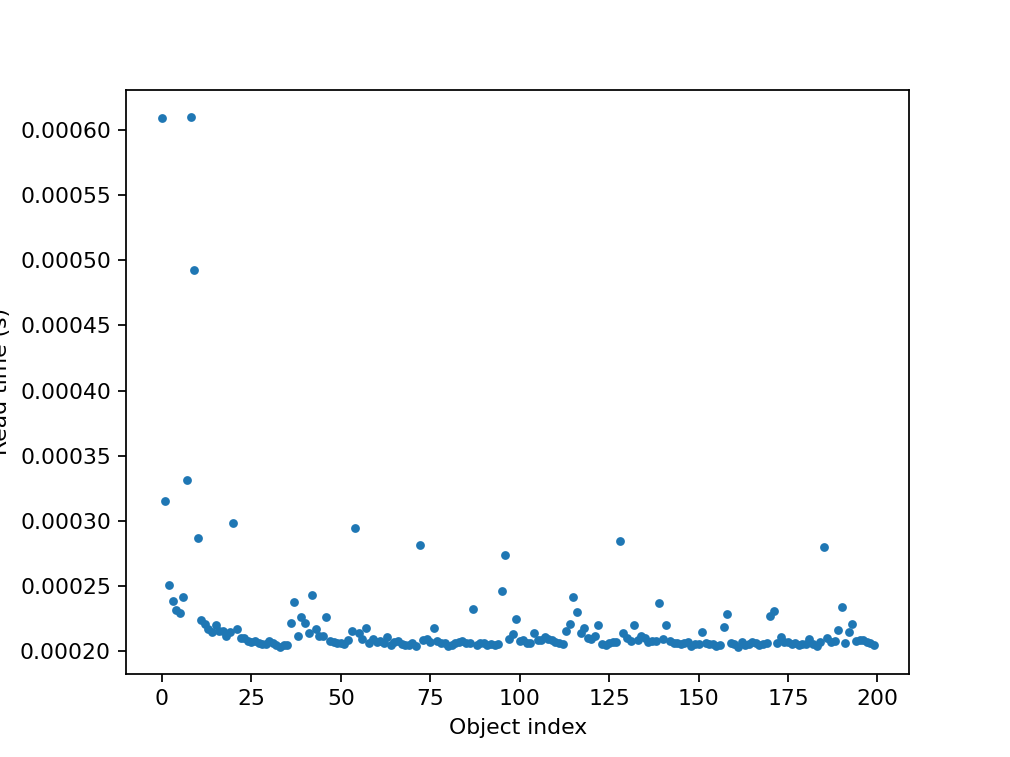

Text(0, 0.5, 'Read time (s)')

In [7]:
%matplotlib notebook

import matplotlib.pyplot as plt

plt.figure("DataArray read times (access by name)")
plt.plot(name_read_times, ".")
plt.xlabel("Object index")
plt.ylabel("Read time (s)")

Fluctuations in the read time are a result of various internal features of the storage backend (HDF5).

Let's also retrieve objects by their **index** and **ID** and look at it all together.

In [8]:
# retrieve each object by its ID and measure time
id_read_times = nix_read_times(blk, da_ids)

# retrieve each object by its index and measure time
obj_index_gen = range(len(da_ids))
idx_read_times = nix_read_times(blk, obj_index_gen)


<IPython.core.display.Javascript object>


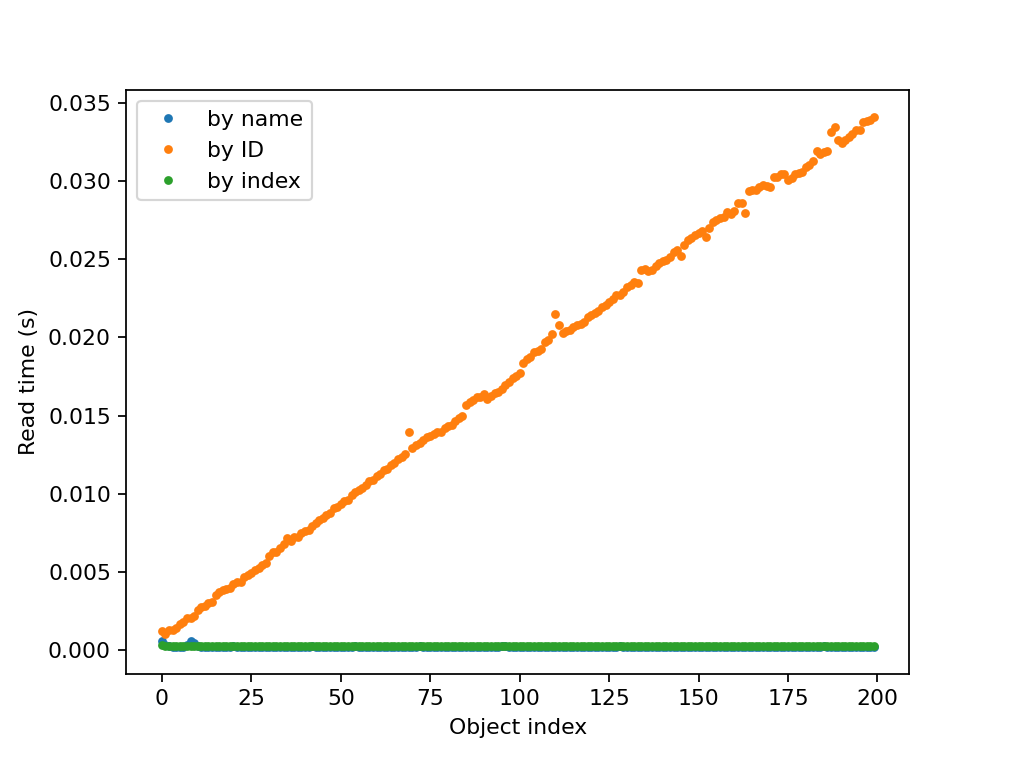

Text(0, 0.5, 'Read time (s)')

In [9]:

plt.figure("Read times")
plt.plot(name_read_times, ".", label="by name")
plt.plot(id_read_times, ".", label="by ID")
plt.plot(idx_read_times, ".", label="by index")
plt.legend(loc="upper left")
plt.xlabel("Object index")
plt.ylabel("Read time (s)")

Retrieving an item by its UUID requires scanning through the list of items to find the object that matches the ID (it performs a linear search).

**Retrieving items by name or index requires only constant time.**

In [10]:
nf.close()

### Linked object retrieval efficiency

Data objects (`DataArray`, `Tag`, `MultiTag`) are created at the top level under a `Block` (e.g., `block.create_data_array(...)`).

Objects can also be grouped after being created, under a group object (e.g., `group.data_arrays_append(da)`).

Objects in **groups** are **linked** through their ID.

This changes the performance behaviour we noted above.  Specifically, retrieving by `name` and by `ID` has the opposite performance characteristics.

In [11]:
nix_filename = os.path.join(workdir, "group_time_retrieve.nix")
nf = nixio.File(nix_filename, nixio.FileMode.Overwrite)
blk = nf.create_block("block-retrieve", "demo-block")
grp = blk.create_group("group-retrieve", "demo-group")

# create 200 data arrays in a block, store their names
# and append them to a single group
da_names = []
da_ids = []
for idx in range(200):
    da_name = f"da-{idx:04}"
    # the actual data being stored is unimportant here
    da = blk.create_data_array(da_name, "demo-data-array", data=[0])
    da_names.append(da_name)
    da_ids.append(da.id)
    grp.data_arrays.append(da)


In [12]:
# retrieve from group by name
name_read_times = nix_read_times(grp, da_names)
 
# retrieve from group by id
id_read_times = nix_read_times(grp, da_ids)
    
# retrieve from group by index
obj_index_gen = range(len(da_ids))
idx_read_times = nix_read_times(grp, obj_index_gen)


<IPython.core.display.Javascript object>


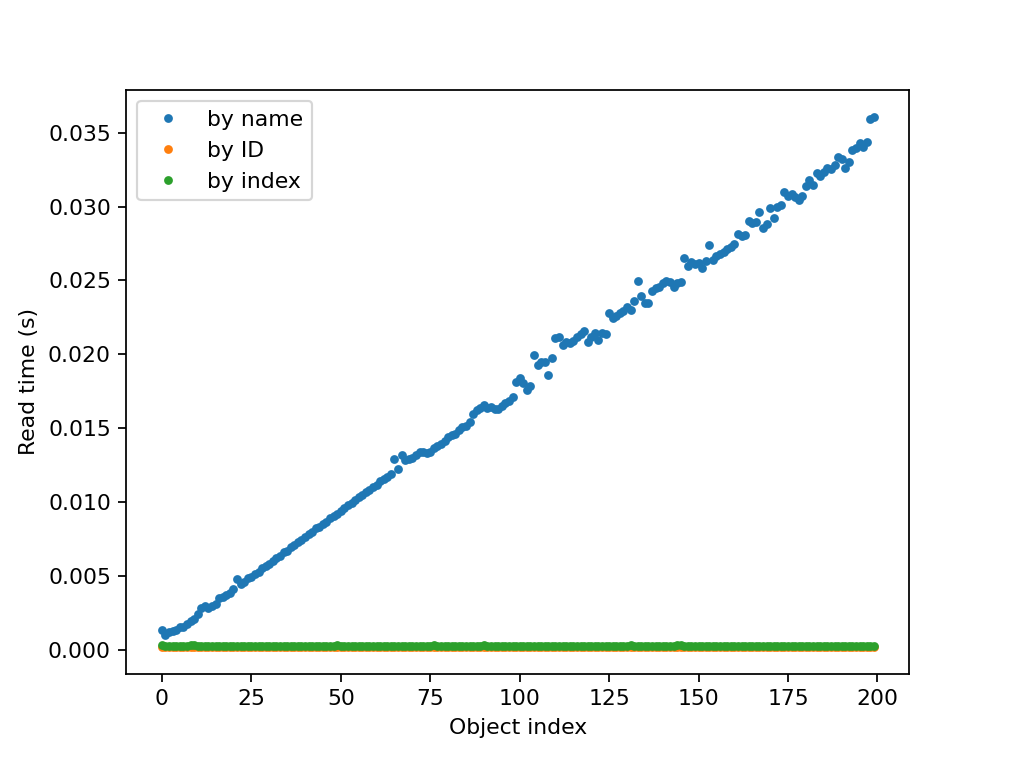

Text(0, 0.5, 'Read time (s)')

In [13]:
plt.figure("Read times (from Group)")
plt.plot(name_read_times, ".", label="by name")
plt.plot(id_read_times, ".", label="by ID")
plt.plot(idx_read_times, ".", label="by index")
plt.legend(loc='upper left')
plt.xlabel("Object index")
plt.ylabel("Read time (s)")

In [14]:
nf.close()

When accessing grouped items:
- access by ID or index
- or keep groups small when planning to acces by name

## Value data types cannot be easily changed

A limitation that comes with HDF5 is that the **data type** of a created **HDF5 dataset** is **immutable**.

For NIX this means, that the underlying data type of an object, once created, cannot be changed.

In particular, if a `DataArray` or a `Property` has been created with a specific data type, this data type cannot be switched to a different one; the Property or the DataArray needs to be created again with the appropriate data type.

Furthermore, if a `Property` is created
- without providing a value from which the data type can be deduced, or
- empty but without providing a data type

this Property will by default be created with value `0` and datatype `int64` and cannot be used for any other values than `int`.

## Removing NIX objects

The underlying Container objects in NIX do not come with built-in `remove` or `delete` methods.

If e.g. Sections or Properties have been created without being required or if Properties have been created with an incorrect data type, you need to use the `del` keyword to remove them.

In [15]:
nix_filename = os.path.join(workdir, "remove_property.nix")
with nixio.File(nix_filename, nixio.FileMode.Overwrite) as nf:
    s = nf.create_section(name="remove_property_example")
    _ = s.create_property(name="to_be_kept")
    _ = s.create_property(name="to_be_removed")
    print(f"Properties before removal: {s.props}")

    del s.props["to_be_removed"]
    print(f"Properties after removal: {s.props}")

Properties before removal: [Property: {name = to_be_kept}, Property: {name = to_be_removed}]
Properties after removal: [Property: {name = to_be_kept}]


# Avoid data inconsistencies - use the NIX file validation

The NIX data model is very flexible.  This lets users structure their data according to their needs and preferences.  
However this can also lead to inconsistent data structures.  While not necessarily *incorrect*, inconsistent data can be harder to interpret.

e.g. DataArrays with missing dimensions, dimensions with missing units or labels, etc

In [16]:
import numpy as np

# random data for demo; equivalent of three recordings
data = np.random.random((3, 100))

# a file with data but no metadata
nix_filename = os.path.join(workdir, "consistency.nix")
with nixio.File(nix_filename, nixio.FileMode.Overwrite) as nf:
    blk = nf.create_block("data", "demo-block")
    da = blk.create_data_array("signal", "demo-array", data=data)

In [17]:
# function that prints the information for a DataArray
#
# This function takes advantage of the structure of the
# nix object model but assumes nothing about our data specifically
def describe_data_array(da):
    print(f"DataArray: {da.name}")
    print(f"Data sample: {da[0, :5]}...")
    print(f"Data shape: {da.shape}")
    print(f"Data unit: {da.unit}")
    print("Dimensions:")
    for dim in da.dimensions:
        print(f"  {dim.index}: {dim.dimension_type}", end=" ")
        if dim.dimension_type == nixio.DimensionType.Set:
            labels = ", ".join(dim.labels)
            print(f"({labels})")
        elif dim.dimension_type == nixio.DimensionType.Sample:
            print(f"(Interval: {dim.sampling_interval} {dim.unit})")
        elif dim.dimension_type == nixio.DimensionType.Range:
            print(f"({len(dim.ticks)} ticks: {dim.ticks[0]}..{dim.ticks[-1]} {dim.unit})")

In [18]:
# the data is stored, but it's virtually meaningless
with nixio.File(nix_filename, nixio.FileMode.ReadOnly) as nf:
    blk = nf.blocks[0]
    da = blk.data_arrays[0]
    
    # print the info of the stored DataArray
    describe_data_array(da)  

DataArray: signal
Data sample: [0.45808357 0.34994916 0.71028435 0.24514032 0.5827772 ]...
Data shape: (3, 100)
Data unit: None
Dimensions:


In [19]:
# the nix validator can show you inconsistencies in a file

# the function runs the validator on a nix file and outputs 
# any Warnings or Errors returned
def validate_and_print(fname):
    with nixio.File(fname, nixio.FileMode.ReadOnly) as nf:
        result = nf.validate()
        errors = result["errors"]
        warnings = result["warnings"]
        
        print(f"Errors: {len(errors)}\nWarnings: {len(warnings)}")

        for item, messages in errors.items():
            msg = ", ".join(messages)
            print(f"[E] {item}: {msg}")
        for item, messages in warnings.items():
            msg = ", ".join(messages)
            print(f"[W] {item}: {msg}")

In [20]:
validate_and_print(nix_filename)

Errors: 1
Warnings: 0
[E] DataArray: {name = signal, type = demo-array}: data dimensionality does not match number of defined dimensions


In [21]:
# let's add the dimensions and run that again
with nixio.File(nix_filename, nixio.FileMode.ReadWrite) as nf:
    blk = nf.blocks[0]
    da = blk.data_arrays[0]

    # Adding dimensions to the DataArray to fully describe the contained data
    da.append_set_dimension(labels=["Signal A", "Signal B", "Signal C"])
    # We assume the recordings were done at a sampling rate
    da.append_sampled_dimension(sampling_interval=0.1, unit="ms")
    da.unit = "mV"

In [22]:
validate_and_print(nix_filename)

Errors: 0
Warnings: 0


In [23]:
with nixio.File(nix_filename, nixio.FileMode.ReadOnly) as nf:
    blk = nf.blocks[0]
    da = blk.data_arrays[0]
    describe_data_array(da)

DataArray: signal
Data sample: [0.45808357 0.34994916 0.71028435 0.24514032 0.5827772 ]...
Data shape: (3, 100)
Data unit: mV
Dimensions:
  1: DimensionType.Set (Signal A, Signal B, Signal C)
  2: DimensionType.Sample (Interval: 0.1 ms)


If the validator returns no errors or warnings, you can be _reasonably certain_ that the data are well described and can be easily plotted and understood.